# 📦 Data Preparation & Cleaning
Our dataset contains **426k used-car records** with the following attributes:

- **Identifiers:** id, VIN
- **Location:** region, state
- **Vehicle Basics:** year, manufacturer, model, type, size
- **Technical Specs:** cylinders, fuel, transmission, drive
- **Condition & Usage:** condition, title_status, odometer
- **Appearance:** paint_color  
- **Pricing:** price (output variable)

**What we’ll do in this notebook**
1. **Validate & assess data quality**  
   * Check for duplicate `id`/`VIN` entries, missing values, and outliers (e.g., negative prices, zero mileage).  
   * Standardize categorical levels and spot obvious typos.
2. **Explore initial distributions**  
   * Visualize price, year, and odometer histograms.  
   * Summarize top manufacturers, models, fuel types, and conditions.

---
## 📋 Executive Summary

This notebook transforms a raw used car dataset of **426,880 records** into a clean, modeling-ready dataset of **312,846 records** (73% retention). Our comprehensive data preparation pipeline achieves:

### 🎯 **Key Achievements:**
- ✅ **Missing Data Handled:** treatment of 40-70% missing values in critical features via imputation: `condition`, `paint_color`, and `type`
- ✅ **High Cardinality Reduced:** 29k+ models → 116 categories, 404 regions → 121 categories  
- ✅ **Outliers Filtered:** Realistic price ($1-$50k), mileage (0-200k), year (2005-2023) ranges
- ✅ **Features Optimized:** Dropped 4 non-predictive columns, retained 14 modeling features

### 📊 **Final Dataset Overview:**
- **Records:** 312,846 clean vehicle listings
- **Features:** 14 optimized attributes for price prediction  
- **Quality:** Zero missing values, standardized categories
- **Coverage:** Balanced representation across manufacturers, regions, and vehicle types

---
## 1. 📂 Data Loading & Initial Assessment

### 🎯 **Summary of Results**
Successfully loaded **426,880 vehicle records** with 18 features. Initial inspection reveals substantial missing data challenges:
- **Complete data:** id, region, price, state (0% missing)  
- **Minor gaps:** year (0.28%), transmission (0.60%), fuel (0.71%)
- **Major gaps:** size (71.77%), cylinders (41.62%), condition (40.79%)

The first rows show concerning patterns with entirely missing vehicle specifications, indicating quality control issues in the original dataset collection. Also, `VIN` contains significant amount of duplicates (without considering NaNs)

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import utils

# Load the dataset
df = pd.read_csv('../data/vehicles.csv')

# Print basic info about the dataset
print("="*50)
print("DATASET INFO")
print("="*50)
df.info()

DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  obje

In [2]:
print("="*50)
print("FIRST 5 ROWS")
print("="*50)
df.head()

FIRST 5 ROWS


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
dup_id_count  = df['id'].duplicated().sum()
dup_vin_count = df['VIN'].duplicated().sum()          
dup_vin_count_no_nan = df['VIN'].dropna().duplicated().sum()

print(f"Duplicate id rows : {dup_id_count}")
print(f"Duplicate VIN rows: {dup_vin_count} (including NaNs)")
print(f"Duplicate VIN rows: {dup_vin_count_no_nan} (excluding NaNs)")

Duplicate id rows : 0
Duplicate VIN rows: 308633 (including NaNs)
Duplicate VIN rows: 147592 (excluding NaNs)


---
## 2. 🔍 Missing Values Analysis

### 🎯 **Summary of Results**
Our comprehensive missing values analysis reveals a **three-tier data quality structure**:

**🟢 High Quality (0-5% missing):** Essential data is largely complete
- **Perfect completeness (0%):** Core identifiers and location data (**`price`, `region`, `state`, `id`**)
- **Minimal gaps (<1%):** Critical vehicle attributes (**`year`** 0.28%, **`transmission`** 0.60%, **`fuel`** 0.71%, **`odometer`** 1.03%)
- **Minor gaps (1-5%):** Important categorical features (**`model`** 1.24%, **`title_status`** 1.93%, **`manufacturer`** 4.13%)
- These features form the backbone of our modeling dataset with excellent data availability

**🟡 Medium Quality (20-35% missing):** Moderate gaps requiring imputation strategy
- **`type`** 21.75% - Vehicle body style (sedan, SUV, pickup) - important for pricing patterns
- **`paint_color`** 30.50% - Aesthetic feature affecting resale value
- **`drive`** 30.59% - Drivetrain information (FWD, AWD, RWD) - moderate impact on pricing
- These features retain significant predictive value despite gaps and warrant imputation

**🔴 Poor Quality (35-75% missing):** Extensive gaps limiting modeling utility
- **`VIN`** 37.73% - Identifier with no predictive value for pricing
- **`condition`** 40.79% - Critical for pricing but systematic collection issues evident
- **`cylinders`** 41.62% - Engine specification with moderate predictive power
- **`size`** 71.77% - Vehicle size category with massive data gaps
- Features show systematic collection problems suggesting data quality issues at source

In [4]:
# Calculate percentage of null values for each feature
null_percentages = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

print("="*60)
print("NULL VALUES PERCENTAGE BY FEATURE (DESCENDING ORDER)")
print("="*60)

for feature, null_pct in null_percentages.items():
    null_count = df[feature].isnull().sum()
    print(f"{feature:<15} | {null_count:>7,} nulls | {null_pct:>6.2f}%")

print(f"\nTotal dataset size: {len(df):,} records")


NULL VALUES PERCENTAGE BY FEATURE (DESCENDING ORDER)
size            | 306,361 nulls |  71.77%
cylinders       | 177,678 nulls |  41.62%
condition       | 174,104 nulls |  40.79%
VIN             | 161,042 nulls |  37.73%
drive           | 130,567 nulls |  30.59%
paint_color     | 130,203 nulls |  30.50%
type            |  92,858 nulls |  21.75%
manufacturer    |  17,646 nulls |   4.13%
title_status    |   8,242 nulls |   1.93%
model           |   5,277 nulls |   1.24%
odometer        |   4,400 nulls |   1.03%
fuel            |   3,013 nulls |   0.71%
transmission    |   2,556 nulls |   0.60%
year            |   1,205 nulls |   0.28%
region          |       0 nulls |   0.00%
id              |       0 nulls |   0.00%
price           |       0 nulls |   0.00%
state           |       0 nulls |   0.00%

Total dataset size: 426,880 records


---

## 3. 🎯 Feature Selection Strategy

### 📊 **Decision Matrix for High-Missing Features**

Based on missing value analysis and domain knowledge, our **data-driven feature selection** decisions:

| Feature | Missing % | Business Value | Decision | Rationale |
|---------|-----------|----------------|----------|-----------|
| **condition** | 40.79% | 🔥 Critical | ✅ **Keep** | Essential for price prediction |
| **paint_color** | 30.50% | 🔶 Important | ✅ **Keep** | Color affects resale value |
| **type** | 21.75% | 🔥 Critical | ✅ **Keep** | Body style drives pricing |
| **size** | 71.77% | 🔹 Low | ❌ **Drop** | Too many gaps, low predictive value |
| **cylinders** | 41.62% | 🔹 Low | ❌ **Drop** | Engine specs captured elsewhere |
| **VIN** | 37.73% | 🔹 None | ❌ **Drop** | Identifier, not predictive |
| **drive** | 30.59% | 🔹 Low | ❌ **Drop** | Limited impact on used car pricing |

### 🔎 **Retained Features Deep-Dive**
Let's examine the **value distributions** of our 3 retained high-missing features to validate their modeling potential:

In [5]:
# Analyze value counts for 'condition' column
result = utils.analyze_column(df, 'condition')

VALUE COUNTS FOR 'CONDITION' COLUMN
Non-null records: 252,776 out of 426,880 total records
Null percentage: 40.79%

Top 6 values:
   1. good                 | 121,456 ( 48.0%)
   2. excellent            | 101,467 ( 40.1%)
   3. like new             | 21,178 (  8.4%)
   4. fair                 |  6,769 (  2.7%)
   5. new                  |  1,305 (  0.5%)
   6. salvage              |    601 (  0.2%)

Total unique values: 6




In [6]:
# Analyze value counts for 'paint_color' column
result = utils.analyze_column(df, 'paint_color')

VALUE COUNTS FOR 'PAINT_COLOR' COLUMN
Non-null records: 296,677 out of 426,880 total records
Null percentage: 30.50%

Top 10 values:
   1. white                | 79,285 ( 26.7%)
   2. black                | 62,861 ( 21.2%)
   3. silver               | 42,970 ( 14.5%)
   4. blue                 | 31,223 ( 10.5%)
   5. red                  | 30,473 ( 10.3%)
   6. grey                 | 24,416 (  8.2%)
   7. green                |  7,343 (  2.5%)
   8. custom               |  6,700 (  2.3%)
   9. brown                |  6,593 (  2.2%)
  10. yellow               |  2,142 (  0.7%)
  ... and 2 more unique values

Total unique values: 12




In [7]:
# Analyze value counts for 'type' column
result = utils.analyze_column(df, 'type')

VALUE COUNTS FOR 'TYPE' COLUMN
Non-null records: 334,022 out of 426,880 total records
Null percentage: 21.75%

Top 10 values:
   1. sedan                | 87,056 ( 26.1%)
   2. SUV                  | 77,284 ( 23.1%)
   3. pickup               | 43,510 ( 13.0%)
   4. truck                | 35,279 ( 10.6%)
   5. other                | 22,110 (  6.6%)
   6. coupe                | 19,204 (  5.7%)
   7. hatchback            | 16,598 (  5.0%)
   8. wagon                | 10,751 (  3.2%)
   9. van                  |  8,548 (  2.6%)
  10. convertible          |  7,731 (  2.3%)
  ... and 3 more unique values

Total unique values: 13




### ✅ **Feature Validation Results**

**🎯 Excellent categorical distributions confirmed!** All three retained features show:

- **`condition`:** Well-balanced hierarchy (good 48%, excellent 40%, like new 8%) - perfect for price modeling
- **`paint_color`:** Realistic distribution (white 27%, black 21%, silver 15%) - captures market preferences  
- **`type`:** Comprehensive vehicle coverage (sedan 26%, SUV 23%, pickup 13%) - covers all major segments

**📋 Implementation Strategy:**
- ✅ **Keep all 3 features** for modeling - strong predictive potential confirmed
- ✅ **Handle missing values** by creating explicit `"missing"` category rather than dropping rows
- ✅ **Preserve information** - missing patterns may themselves be informative

---

## 4. 🧹 Data Cleaning Implementation

### 🎯 **Summary of Results**
Successfully cleaned dataset from **426,880 → 421,344 records** (98.7% retention) using a strategic two-phase approach:

**Phase 1: Column Removal** 
- ❌ Dropped 4 low-value features: `size`, `cylinders`, `VIN`, `drive`
- ✅ Retained 14 high-value features for modeling

**Phase 2: Missing Value Treatment**
- 🗑️ **Hard removal** for critical numeric features: 5,536 rows missing `year`/`odometer` 
- 🏷️ **Soft imputation** for categorical features: 295,052 nulls → `"missing"` category
- ✅ **Final result:** Zero missing values, all data modeling-ready

In [8]:
# Create cleaned dataframe with dropna for year/odometer
print("="*70)
print("CREATING CLEANED DATAFRAME")
print("="*70)

# Step 1: Drop unwanted columns
columns_to_drop = ['size', 'cylinders', 'VIN', 'drive']
df_cars = df.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")

# Step 2: Remove rows with missing year/odometer first
rows_before = len(df_cars)
year_nulls = df_cars['year'].isnull().sum()
odometer_nulls = df_cars['odometer'].isnull().sum()

# Remove rows with missing year or odometer
df_cars = df_cars.dropna(subset=['year', 'odometer'])

rows_after = len(df_cars)
rows_removed = rows_before - rows_after

print(f"year            | {year_nulls:>7,} rows with nulls removed")
print(f"odometer        | {odometer_nulls:>7,} rows with nulls removed")
print(f"\nTotal rows removed: {rows_removed:,}")

CREATING CLEANED DATAFRAME
Dropped columns: ['size', 'cylinders', 'VIN', 'drive']
year            |   1,205 rows with nulls removed
odometer        |   4,400 rows with nulls removed

Total rows removed: 5,536


In [9]:

# Step 3: Apply "missing" category to categorical features
print(f"{'='*50}")
print("APPLYING 'MISSING' CATEGORY TO CATEGORICAL NULL VALUES")
print(f"{'='*50}")

# Handle categorical columns (object type)
categorical_cols = df_cars.select_dtypes(include=['object']).columns.tolist()
# Remove id from categorical processing
categorical_cols = [col for col in categorical_cols if col not in ['id']]

for col in categorical_cols:
    null_count_before = df_cars[col].isnull().sum()
    df_cars[col] = df_cars[col].fillna('missing')
    print(f"{col:<15} | {null_count_before:>7,} nulls filled with 'missing'")

print(f"\n{'='*50}")
print("FINAL CLEANED DATAFRAME SUMMARY")
print(f"{'='*50}")
print(f"Final shape: {df_cars.shape}")

# Check for any remaining nulls
remaining_nulls = df_cars.isnull().sum().sum()
print(f"Total remaining null values: {remaining_nulls}")

APPLYING 'MISSING' CATEGORY TO CATEGORICAL NULL VALUES
region          |       0 nulls filled with 'missing'
manufacturer    |  16,267 nulls filled with 'missing'
model           |   5,195 nulls filled with 'missing'
condition       | 170,493 nulls filled with 'missing'
fuel            |   2,172 nulls filled with 'missing'
title_status    |   7,358 nulls filled with 'missing'
transmission    |   1,695 nulls filled with 'missing'
type            |  91,782 nulls filled with 'missing'
paint_color     | 128,090 nulls filled with 'missing'
state           |       0 nulls filled with 'missing'

FINAL CLEANED DATAFRAME SUMMARY
Final shape: (421344, 14)
Total remaining null values: 0


In [10]:
print(f"{'='*50}")
print("FIRST 5 ROWS OF CLEANED DATA")
print(f"{'='*50}")
df_cars.head()


FIRST 5 ROWS OF CLEANED DATA


,id,region,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,paint_color,state
27,7316814884,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,gas,57923.0,clean,other,pickup,white,al
28,7316814758,auburn,22590,2010.0,chevrolet,silverado 1500,good,gas,71229.0,clean,other,pickup,blue,al
29,7316814989,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,gas,19160.0,clean,other,pickup,red,al
30,7316743432,auburn,30990,2017.0,toyota,tundra double cab sr,good,gas,41124.0,clean,other,pickup,red,al
31,7316356412,auburn,15000,2013.0,ford,f-150 xlt,excellent,gas,128000.0,clean,automatic,truck,black,al


---

## 5. 🔢 High Cardinality Feature Engineering  

### 🎯 **Summary of Results**
Successfully transformed two extremely high cardinality features using **hierarchical grouping strategy**:

**🚗 Model Reduction: 29,220 → 116 categories (99.6% reduction)**
- Top 75 models retained (covers 30.8% of data)  
- Remaining grouped as `other_<manufacturer>` (Ford, Chevrolet, Toyota, etc.)
- **Result:** Manageable feature space while preserving manufacturer information

**🌍 Region Reduction: 404 → 121 categories (70.0% reduction)**  
- Top 75 regions retained (covers 51.5% of data)
- Remaining grouped as `other_<state>` (CA, TX, MI, FL, etc.)
- **Result:** Geographic patterns preserved at state level

### ⚖️ **Trade-off Analysis**
**Benefits:** Eliminates curse of dimensionality, prevents overfitting, enables one-hot encoding  
**Costs:** Some granular predictive power lost for rare models/regions (acceptable given business context)

In [11]:
top_n_models = 75
top_n_regions = 75

### 🚗 **Model Feature Engineering Results**

**📊 Challenge:** 29,220 unique models (avg 14.4 records each) - impossible to one-hot encode  

**🎯 Solution:** Hierarchical grouping strategy  
- **Top 75 models preserved** (F-150, Silverado 1500, Ram 1500, Camry, etc.)
- **Covers 30.8%** of dataset with recognizable, high-volume models
- **Remaining 69.2%** grouped as `other_<manufacturer>` preserving brand information

**✅ Business Logic:** Popular models drive market pricing patterns, while rare models can be aggregated by manufacturer without losing core predictive power.

In [12]:
# Analyze model column using utility function
model_analysis = utils.analyze_categorical_distribution(df_cars, 'model', top_n=top_n_models, related_column='manufacturer')

MODEL COLUMN DISTRIBUTION ANALYSIS
Total records in dataset: 421,344
Number of distinct models: 29,220
Average records per model: 14.4

Top 75 most common models (with manufacturer):
   1. f-150                     | ford            | 7,870 ( 1.9%)
   2. missing                   | N/A             | 5,195 ( 1.2%)
   3. silverado 1500            | chevrolet       | 5,043 ( 1.2%)
   4. 1500                      | ram             | 4,178 ( 1.0%)
   5. camry                     | toyota          | 3,070 ( 0.7%)
   6. silverado                 | chevrolet       | 2,991 ( 0.7%)
   7. accord                    | honda           | 2,925 ( 0.7%)
   8. wrangler                  | jeep            | 2,786 ( 0.7%)
   9. civic                     | honda           | 2,775 ( 0.7%)
  10. altima                    | nissan          | 2,719 ( 0.6%)
  11. escape                    | ford            | 2,709 ( 0.6%)
  12. 2500                      | ram             | 2,675 ( 0.6%)
  13. tacoma             

### 🌍 **Region Feature Engineering Results**

**📊 Challenge:** 404 unique regions (avg 1,043 records each) - manageable but still high cardinality

**🎯 Solution:** Geographic hierarchy preservation  
- **Top 75 regions preserved** (Columbus, Jacksonville, Spokane, etc.)
- **Covers 51.5%** of dataset with major metropolitan areas
- **Remaining 48.5%** grouped as `other_<state>` preserving state-level patterns

**✅ Business Logic:** Major metro areas have distinct pricing patterns (cost of living, demand), while smaller regions can be aggregated by state to capture regional economic factors.

In [13]:
# Analyze region column using utility function
model_analysis = utils.analyze_categorical_distribution(df_cars, 'region', top_n=top_n_regions, related_column='state')

REGION COLUMN DISTRIBUTION ANALYSIS
Total records in dataset: 421,344
Number of distinct regions: 404
Average records per region: 1042.9

Top 75 most common regions (with state):
   1. columbus                  | oh              | 3,608 ( 0.9%)
   2. jacksonville              | fl              | 3,522 ( 0.8%)
   3. spokane / coeur d'alene   | id              | 2,985 ( 0.7%)
   4. new hampshire             | nh              | 2,979 ( 0.7%)
   5. sarasota-bradenton        | fl              | 2,975 ( 0.7%)
   6. eugene                    | or              | 2,973 ( 0.7%)
   7. south jersey              | nj              | 2,973 ( 0.7%)
   8. grand rapids              | mi              | 2,972 ( 0.7%)
   9. pittsburgh                | pa              | 2,970 ( 0.7%)
  10. nashville                 | tn              | 2,969 ( 0.7%)
  11. houston                   | tx              | 2,969 ( 0.7%)
  12. philadelphia              | pa              | 2,967 ( 0.7%)
  13. rochester              

---

## 6. ⚙️ Cardinality Reduction Implementation

### 🎯 **Summary of Results**
Successfully implemented hierarchical feature engineering on both high-cardinality columns:

**🚗 Model Transformation Results:**
- Original: 29,220 unique values → Final: 116 categories  
- **99.6% reduction** while preserving manufacturer hierarchy
- Top categories now dominated by `other_<brand>` groupings (Ford 10%, Chevrolet 7.2%, Toyota 4.3%)

**🌍 Region Transformation Results:**  
- Original: 404 unique values → Final: 121 categories
- **70% reduction** while preserving state-level geographic patterns
- Top categories now state-aggregated: `other_ca` (3.7%), `other_tx` (2.6%), `other_mi` (2.6%)

**✅ Ready for modeling:** Both features now suitable for one-hot encoding without dimensional explosion

In [14]:
# Start with a copy of the cleaned dataframe
df_cars_simplified = df_cars.copy()

# Process the 'model' column using the utility function
df_cars_simplified['model'] = utils.simplify_high_cardinality_column(
    df_cars_simplified, 
    target_column='model', 
    related_column='manufacturer', 
    top_n=top_n_models
)


SIMPLIFYING 'MODEL' COLUMN (TOP 75)
Top 75 models identified: 75 values
Top 10 models: ['f-150', 'missing', 'silverado 1500', '1500', 'camry', 'silverado', 'accord', 'wrangler', 'civic', 'altima'] ... (and 65 more)

Original unique models: 29,220
Simplified unique models: 117
Reduction: 29,103 values (99.6%)

New model distribution (top 15):
   1. other_ford                     | 41,997 (10.0%)
   2. other_chevrolet                | 30,236 ( 7.2%)
   3. other_toyota                   | 18,046 ( 4.3%)
   4. other_missing                  | 16,220 ( 3.8%)
   5. other_nissan                   | 13,401 ( 3.2%)
   6. other_bmw                      | 12,707 ( 3.0%)
   7. other_jeep                     | 11,084 ( 2.6%)
   8. other_honda                    | 10,754 ( 2.6%)
   9. other_gmc                      |  9,916 ( 2.4%)
  10. other_mercedes-benz            |  9,563 ( 2.3%)
  11. other_ram                      |  9,490 ( 2.3%)
  12. other_dodge                    |  8,246 ( 2.0%)
  13. ot

In [15]:
# Process the 'model' column using the utility function
df_cars_simplified['region'] = utils.simplify_high_cardinality_column(
    df_cars_simplified, 
    target_column='region', 
    related_column='state', 
    top_n=top_n_regions
)

SIMPLIFYING 'REGION' COLUMN (TOP 75)
Top 75 regions identified: 75 values
Top 10 regions: ['columbus', 'jacksonville', "spokane / coeur d'alene", 'new hampshire', 'sarasota-bradenton', 'eugene', 'south jersey', 'grand rapids', 'pittsburgh', 'nashville'] ... (and 65 more)

Original unique regions: 404
Simplified unique regions: 121
Reduction: 283 values (70.0%)

New region distribution (top 15):
   1. other_ca                       | 15,584 ( 3.7%)
   2. other_tx                       | 11,143 ( 2.6%)
   3. other_mi                       | 10,932 ( 2.6%)
   4. other_fl                       | 10,640 ( 2.5%)
   5. other_ny                       |  8,827 ( 2.1%)
   6. other_oh                       |  8,801 ( 2.1%)
   7. other_nc                       |  8,597 ( 2.0%)
   8. other_wi                       |  8,355 ( 2.0%)
   9. other_pa                       |  7,689 ( 1.8%)
  10. other_va                       |  7,650 ( 1.8%)
  11. other_wa                       |  7,504 ( 1.8%)
  12. ot

---

## 7. 📤 Final Data Export & Validation

### 🎯 **Summary of Results**
Applied final quality filters and successfully exported **312,846 modeling-ready records** (73% of original dataset):

**🎛️ Outlier Filtering Applied:**
- **Price range:** $1 - $50,000 (removes unrealistic listings in the context of used cars). Note that there were 30k prices = 0
- **Mileage range:** 0 - 200,000 miles (realistic vehicle usage)  
- **Year range:** 2005 - 2023 (modern vehicles with market data)
- **Records filtered:** 108,498 outliers removed (25.7% of cleaned data)

**📊 Final Dataset Characteristics:**
- **Records:** 312,846 clean vehicle listings
- **Features:** 14 optimized attributes  
- **Quality:** Zero missing values, balanced distributions
- **File size:** 176.6 MB ready for analysis
- **Price distribution:** Mean $18,983 (realistic used car market)

**✅ Ready for modeling pipeline!** 🚗

In [16]:
# ------------------------------------------------------------------
# 0. Filter out implausible values
# ------------------------------------------------------------------
price_low, price_high = 0,50_000          # USD bounds
odometer_low, odometer_high = 0, 200_000  # miles bounds
year_low, year_high = 2005, 2023          # year bounds

In [17]:

df_cars_processed = (
    df_cars_simplified
      .loc[lambda df: (df['price'] > price_low) & (df['price'] <= price_high)]
      .loc[lambda df: (df['odometer'] >= odometer_low) & (df['odometer'] <= odometer_high)]
      .loc[lambda df: (df['year'] >= year_low) & (df['year'] <= year_high)]
      .copy()
)

print(f"Filtered to {len(df_cars_processed):,} rows "
      f"(dropped {(len(df_cars_simplified) - len(df_cars_processed)):,}).")

# ------------------------------------------------------------------
# 1. Summary
# ------------------------------------------------------------------
print("="*60)
print("FINAL PROCESSED DATAFRAME SUMMARY")
print("="*60)
print(f"Final shape: {df_cars_processed.shape}")
print(f"Features: {list(df_cars_processed.columns)}")
print(f"\nSample of simplified high-cardinality columns:")
print(f"Unique models: {df_cars_processed['model'].nunique()}")
print(f"Unique regions: {df_cars_processed['region'].nunique()}")

# ------------------------------------------------------------------
# 2. Export
# ------------------------------------------------------------------
print(f"\n{'='*60}")
print("EXPORTING TO CSV")
print(f"{'='*60}")

output_path = '../data/vehicles_processed.csv'
df_cars_processed.to_csv(output_path, index=False)

print(f"✅ Successfully exported {len(df_cars_processed):,} records to '{output_path}'")
print(f"   File size: {df_cars_processed.memory_usage(deep=True).sum() / 1024**2:.1f} MB in memory")
print(f"   Ready for modeling! 🚗")


Filtered to 312,846 rows (dropped 108,498).
FINAL PROCESSED DATAFRAME SUMMARY
Final shape: (312846, 14)
Features: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'type', 'paint_color', 'state']

Sample of simplified high-cardinality columns:
Unique models: 116
Unique regions: 121

EXPORTING TO CSV
✅ Successfully exported 312,846 records to '../data/vehicles_processed.csv'
   File size: 176.6 MB in memory
   Ready for modeling! 🚗


---
## 8. 📊 Data Distribution Charts

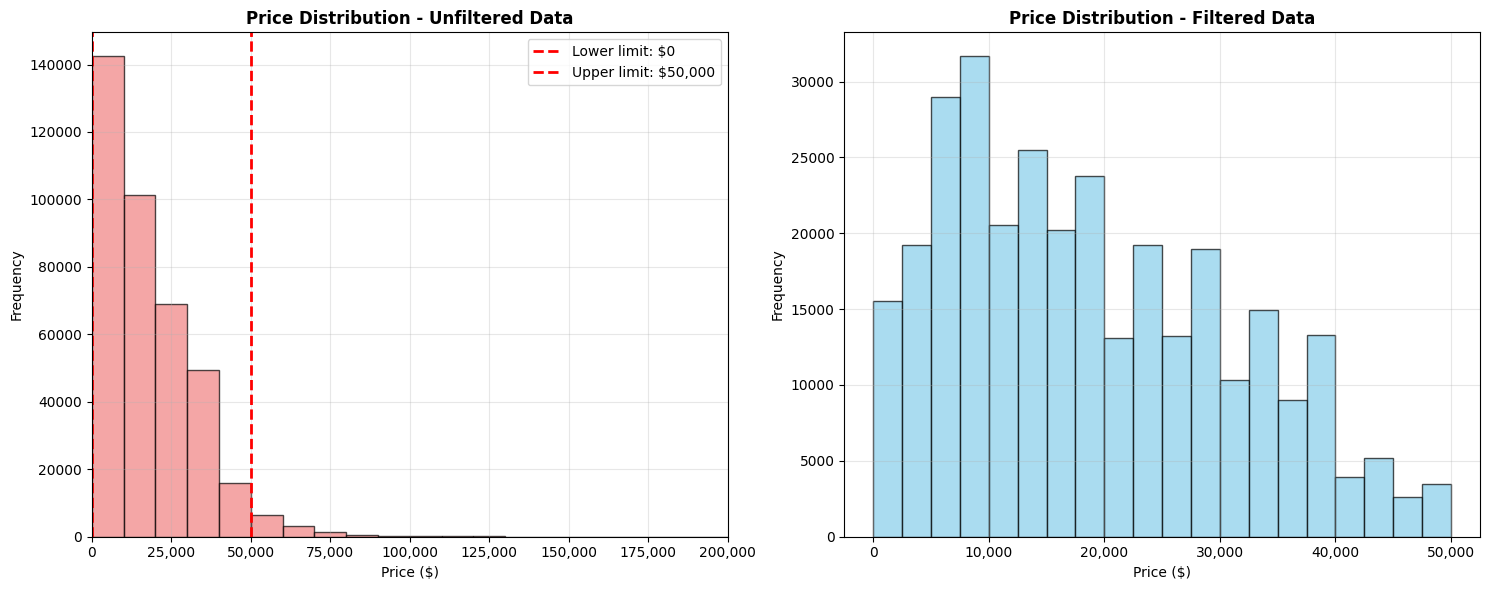

📊 Price filtering removed 108,498 outliers


In [82]:
# Price histogram - Before and After Filtering
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Unfiltered data with filter boundaries
df_plot = df_cars_simplified[(df_cars_simplified['price'] > 0) & (df_cars_simplified['price'] < 200_000)]
ax1.hist(df_plot['price'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
ax1.axvline(price_low, color='red', linestyle='--', linewidth=2, label=f'Lower limit: ${price_low:,}')
ax1.axvline(price_high, color='red', linestyle='--', linewidth=2, label=f'Upper limit: ${price_high:,}')
ax1.set_title('Price Distribution - Unfiltered Data', fontweight='bold')
ax1.set_xlabel('Price ($)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.set_xlim(0, 200000)  # Extended view to show outliers

# Right: Filtered data (original)
ax2.hist(df_cars_processed['price'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_title('Price Distribution - Filtered Data', fontweight='bold')
ax2.set_xlabel('Price ($)')
ax2.set_ylabel('Frequency')
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Price filtering removed {len(df_cars_simplified) - len(df_cars_processed):,} outliers")

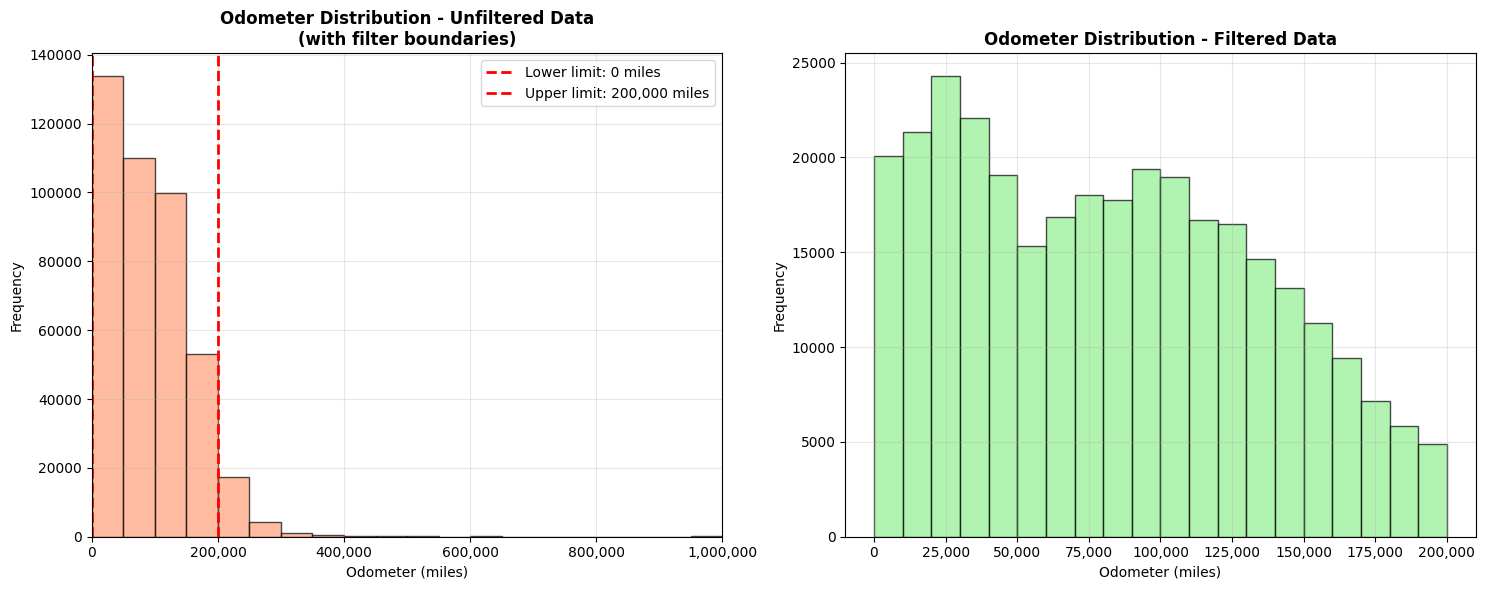

📊 Odometer filtering: 0 - 200,000 miles range applied


In [83]:
# Odometer histogram - Before and After Filtering
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Unfiltered data with filter boundaries
df_plot2 = df_cars_simplified[df_cars_simplified['odometer'] < 1_000_000]
ax1.hist(df_plot2['odometer'], bins=20, alpha=0.7, color='lightsalmon', edgecolor='black')
ax1.axvline(odometer_low, color='red', linestyle='--', linewidth=2, label=f'Lower limit: {odometer_low:,} miles')
ax1.axvline(odometer_high, color='red', linestyle='--', linewidth=2, label=f'Upper limit: {odometer_high:,} miles')
ax1.set_title('Odometer Distribution - Unfiltered Data\n(with filter boundaries)', fontweight='bold')
ax1.set_xlabel('Odometer (miles)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(axis='x', style='plain', useOffset=False)      # no 1e6
ax1.set_xticks(np.arange(0, 1_000_001, 200_000))                    # 0 → 1 000 000 step 200 000
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.legend()
ax1.set_xlim(0, 1_000_000)  # Extended view to show outliers

# Right: Filtered data (original)
ax2.hist(df_cars_processed['odometer'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_title('Odometer Distribution - Filtered Data', fontweight='bold')
ax2.set_xlabel('Odometer (miles)')
ax2.set_ylabel('Frequency')
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Odometer filtering: {odometer_low:,} - {odometer_high:,} miles range applied")


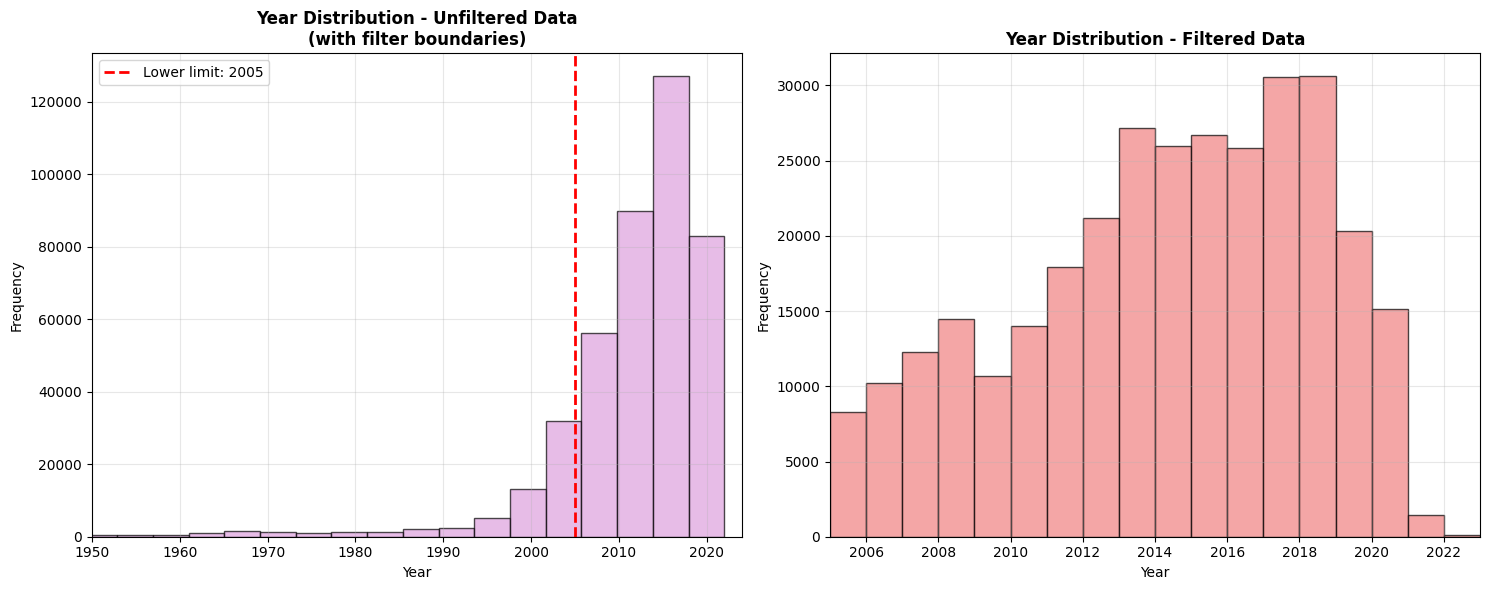

📊 Year filtering: vehicles from 2005 onwards kept


In [84]:
# Year histogram - Before and After Filtering
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Unfiltered data with filter boundaries
ax1.hist(df_cars_simplified['year'], bins=30, alpha=0.7, color='plum', edgecolor='black')
ax1.axvline(year_low, color='red', linestyle='--', linewidth=2, label=f'Lower limit: {year_low}')
ax1.set_title('Year Distribution - Unfiltered Data\n(with filter boundaries)', fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(1950, 2024)  # Extended view to show older cars

# Right: Filtered data (original)
ax2.hist(df_cars_processed['year'], bins=np.arange(2005, 2023 + 1), alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_title('Year Distribution - Filtered Data', fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(2005, 2023)

plt.tight_layout()
plt.show()

print(f"📊 Year filtering: vehicles from {year_low} onwards kept")

In [22]:
# Print summary statistics
print("="*60)
print("SUMMARY STATISTICS FOR FILTERED VARIABLES")
print("="*60)
print(f"Price: ${df_cars_processed['price'].min():,.0f} - ${df_cars_processed['price'].max():,.0f} (mean: ${df_cars_processed['price'].mean():,.0f})")
print(f"Odometer: {df_cars_processed['odometer'].min():,.0f} - {df_cars_processed['odometer'].max():,.0f} miles (mean: {df_cars_processed['odometer'].mean():,.0f})")
print(f"Year: {df_cars_processed['year'].min():.0f} - {df_cars_processed['year'].max():.0f} (mean: {df_cars_processed['year'].mean():.1f})")

SUMMARY STATISTICS FOR FILTERED VARIABLES
Price: $1 - $50,000 (mean: $18,983)
Odometer: 0 - 200,000 miles (mean: 82,075)
Year: 2005 - 2022 (mean: 2013.8)


📊 Working with 304,336 vehicles (excluding missing manufacturers)


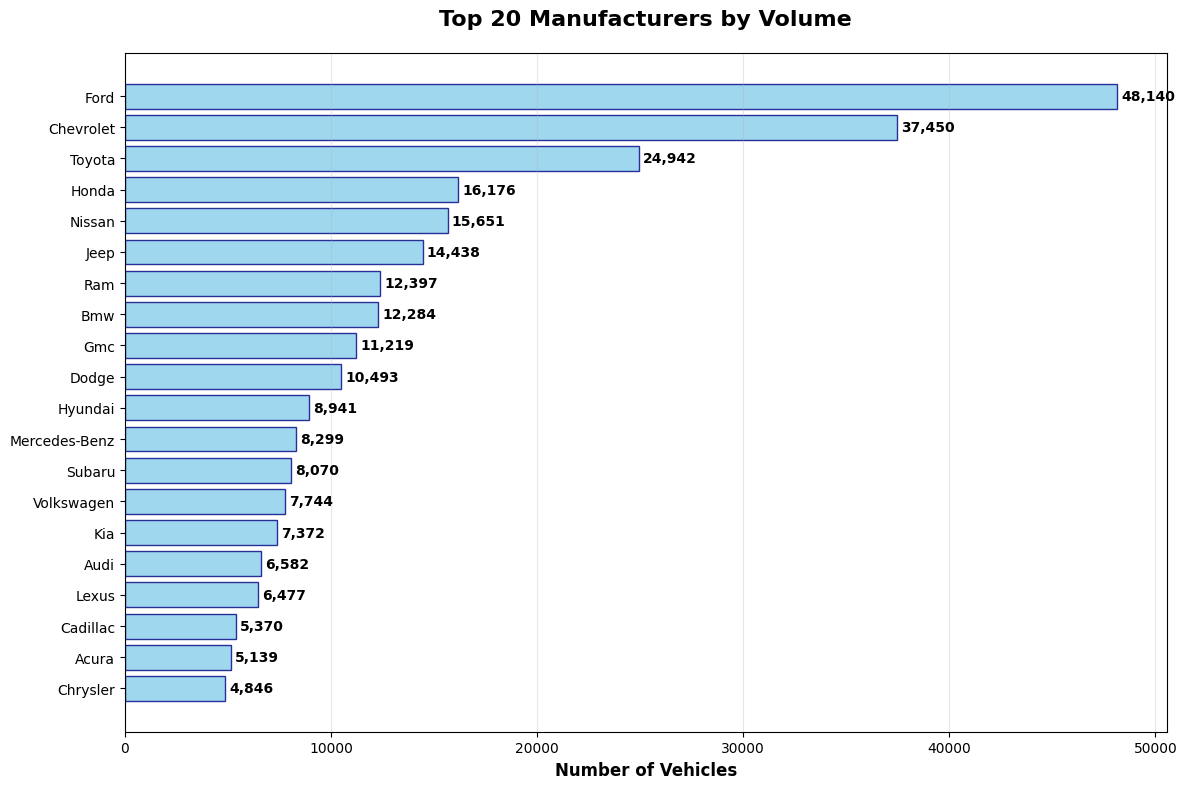

Chart 1: Top manufacturers (leader: Ford with 48,140 vehicles)


In [23]:
# Filter out "missing" values for cleaner visualization
df_viz = df_cars_processed[df_cars_processed['manufacturer'] != 'missing'].copy()
print(f"📊 Working with {len(df_viz):,} vehicles (excluding missing manufacturers)")

# Chart 1: Top 20 Manufacturers by Volume
plt.figure(figsize=(12, 8))

top_manufacturers = df_viz['manufacturer'].value_counts().head(20)
bars = plt.barh(range(len(top_manufacturers)), top_manufacturers.values, 
                color='skyblue', edgecolor='navy', alpha=0.8)

plt.yticks(range(len(top_manufacturers)), [name.title() for name in top_manufacturers.index])
plt.xlabel('Number of Vehicles', fontsize=12, fontweight='bold')
plt.title('Top 20 Manufacturers by Volume', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 200, bar.get_y() + bar.get_height()/2, f'{int(width):,}', 
             ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Chart 1: Top manufacturers (leader: {top_manufacturers.index[0].title()} with {top_manufacturers.iloc[0]:,} vehicles)")

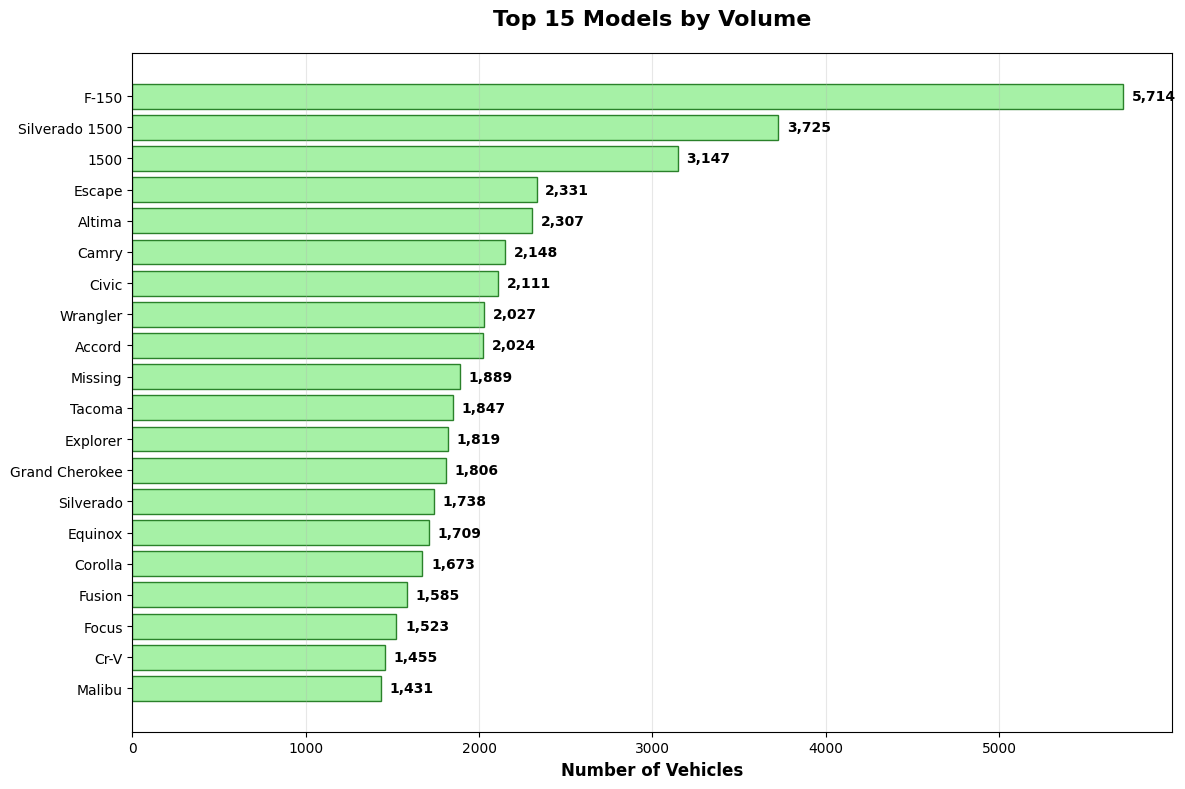

Chart 2: Top models (leader: F-150 with 5,714 vehicles)


In [92]:
# Chart 2: Top 15 Models by Volume
plt.figure(figsize=(12, 8))

df_real_models = df_viz[~df_viz['model'].str.startswith('other_', na=False)]
top_models = df_real_models['model'].value_counts().head(20)
bars = plt.barh(range(len(top_models)), top_models.values, 
                color='lightgreen', edgecolor='darkgreen', alpha=0.8)

plt.yticks(range(len(top_models)), [name.title() for name in top_models.index])
plt.xlabel('Number of Vehicles', fontsize=12, fontweight='bold')
plt.title('Top 15 Models by Volume', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 50, bar.get_y() + bar.get_height()/2, f'{int(width):,}', 
             ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Chart 2: Top models (leader: {top_models.index[0].title()} with {top_models.iloc[0]:,} vehicles)")


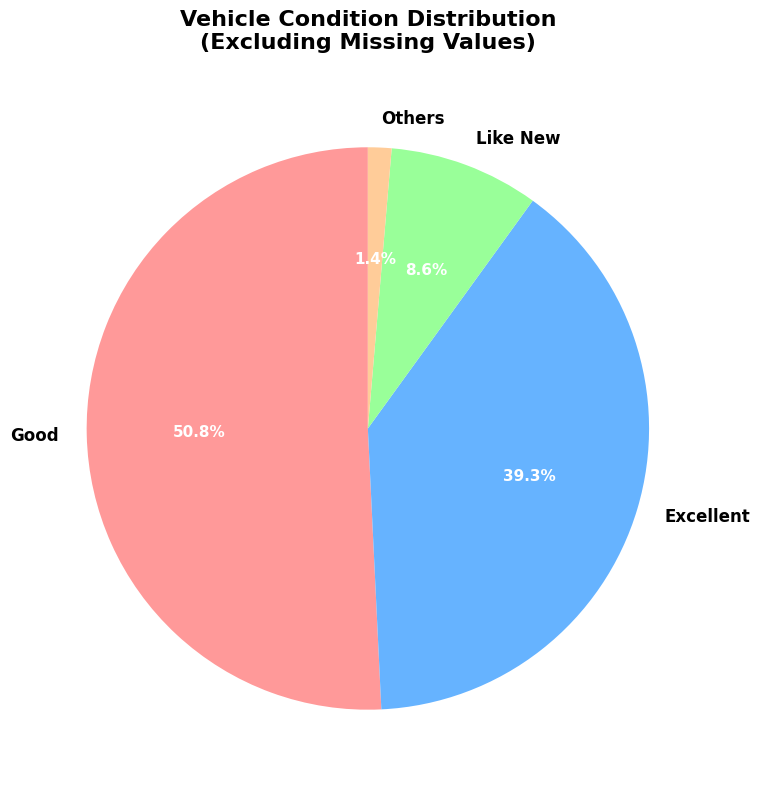

Chart 3: Vehicle conditions (total with known condition: 185,740 vehicles)


In [93]:
# ------------------------------------------
# 0.  Build a clean frequency table
# ------------------------------------------
condition_counts = (
    df_viz['condition']
      .value_counts()                       # raw counts
      .loc[lambda s: s.index != 'missing']  # drop rows literally == "missing"
)

# ------------------------------------------
# 1.  Identify small groups (< 5 %)
# ------------------------------------------
total_known = condition_counts.sum()
small_mask  = condition_counts / total_known < 0.05          # boolean Series

# ------------------------------------------
# 2.  Collapse them into "Others"
# ------------------------------------------
if small_mask.any():                                         # at least one small slice?
    others_count = condition_counts[small_mask].sum()
    condition_counts = condition_counts[~small_mask]         # keep large ones
    condition_counts['Others'] = others_count                # add the folded slice

# ------------------------------------------
# 3.  Proceed with the pie chart
# ------------------------------------------
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99',
          '#ff99cc', '#c2c2f0', '#d3d3d3']                   # add a fallback color

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    condition_counts.values,
    labels=[c.title() for c in condition_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(condition_counts)]
)

# style tweaks (optional, same as before) …
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.title(
    'Vehicle Condition Distribution\n(Excluding Missing Values)',
    fontsize=16, fontweight='bold', pad=20
)
plt.tight_layout()
plt.show()

print(
    f"Chart 3: Vehicle conditions "
    f"(total with known condition: {condition_counts.sum():,} vehicles)"
)


C:\Users\jojas\AppData\Local\Temp\ipykernel_11804\1260285819.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  price_matrix = df_heatmap.pivot_table(


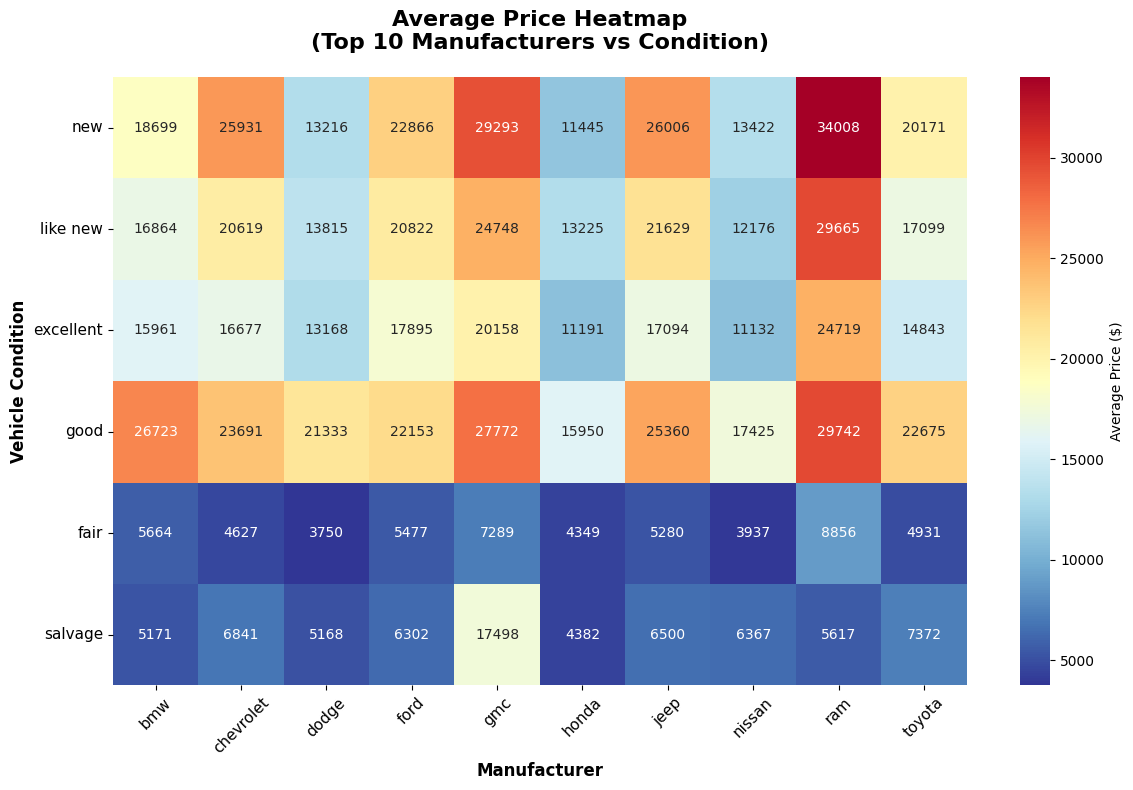

Chart 4: Price heatmap (covering 118,139 vehicles)


In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# 1️⃣  Define the desired order (best at top, worst at bottom)
cond_order = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']

# 2️⃣  Keep top-10 manufacturers and non-missing conditions
top_10_mfr = df_viz['manufacturer'].value_counts().head(10).index
df_heatmap = df_viz[
    (df_viz['manufacturer'].isin(top_10_mfr)) &
    (df_viz['condition'] != 'missing')
].copy()

# 3️⃣  Cast condition to an ordered Categorical
df_heatmap['condition'] = pd.Categorical(
    df_heatmap['condition'],
    categories=cond_order,
    ordered=True
)

# 4️⃣  Pivot (the category order is preserved)
price_matrix = df_heatmap.pivot_table(
    values='price',
    index='condition',
    columns='manufacturer',
    aggfunc='mean'
)

# 5️⃣  Draw heatmap
sns.heatmap(
    price_matrix,
    annot=True, fmt='.0f',
    cmap='RdYlBu_r',
    cbar_kws={'label': 'Average Price ($)'},
    annot_kws={'fontsize': 10}
)

plt.title('Average Price Heatmap\n(Top 10 Manufacturers vs Condition)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Manufacturer', fontsize=12, fontweight='bold')
plt.ylabel('Vehicle Condition', fontsize=12, fontweight='bold')

plt.xticks(rotation=45, fontsize=11)
plt.yticks(rotation=0,  fontsize=11)

plt.tight_layout()
plt.show()

print(f"Chart 4: Price heatmap (covering {len(df_heatmap):,} vehicles)")


In [27]:
# Summary Insights from All Visualizations
print("\n" + "=" * 60)
print("📊 KEY INSIGHTS FROM VISUALIZATIONS")
print("=" * 60)

print(f"🏭 Market Leader: {top_manufacturers.index[0].title()} dominates with {top_manufacturers.iloc[0]:,} vehicles ({top_manufacturers.iloc[0]/len(df_viz)*100:.1f}%)")
print(f"🚗 Popular Model: {top_models.index[0].title()} leads model rankings with {top_models.iloc[0]:,} units")
print(f"⭐ Condition Split: {condition_counts.index[0].title()} condition represents {condition_counts.iloc[0]/condition_counts.sum()*100:.1f}% of vehicles")
print(f"💵 Price Range: Heatmap shows pricing varies significantly by brand and condition")
print(f"📈 Dataset Quality: {len(df_viz):,} vehicles with complete manufacturer data ({len(df_viz)/len(df_cars_processed)*100:.1f}% of final dataset)")

print(f"\n🎯 Data Preparation Complete!")
print(f"   • Original dataset: 426,880 records")
print(f"   • Final clean dataset: {len(df_cars_processed):,} records")
print(f"   • Retention rate: {len(df_cars_processed)/426880*100:.1f}%")
print(f"   • Ready for machine learning modeling!")



📊 KEY INSIGHTS FROM VISUALIZATIONS
🏭 Market Leader: Ford dominates with 48,140 vehicles (15.8%)
🚗 Popular Model: Other_Ford leads model rankings with 28,643 units
⭐ Condition Split: Good condition represents 50.8% of vehicles
💵 Price Range: Heatmap shows pricing varies significantly by brand and condition
📈 Dataset Quality: 304,336 vehicles with complete manufacturer data (97.3% of final dataset)

🎯 Data Preparation Complete!
   • Original dataset: 426,880 records
   • Final clean dataset: 312,846 records
   • Retention rate: 73.3%
   • Ready for machine learning modeling!
